
--- Perhitungan dengan Split Dataset 70:30 ---
Jumlah kelas (k): 7
A1: 3077.0 - 3131.0 dengan nilai median 3104.0
A2: 3131.0 - 3185.0 dengan nilai median 3158.0
A3: 3185.0 - 3239.0 dengan nilai median 3212.0
A4: 3239.0 - 3293.0 dengan nilai median 3266.0
A5: 3293.0 - 3347.0 dengan nilai median 3320.0
A6: 3347.0 - 3401.0 dengan nilai median 3374.0
A7: 3401.0 - 3455.0 dengan nilai median 3428.0
MAPE pada set validasi (30% data): 1.26858%

--- Perhitungan dengan File Validasi Eksternal ---
Jumlah kelas (k): 8
A1: 3077.0 - 3124.25 dengan nilai median 3100.625
A2: 3124.25 - 3171.5 dengan nilai median 3147.875
A3: 3171.5 - 3218.75 dengan nilai median 3195.125
A4: 3218.75 - 3266.0 dengan nilai median 3242.375
A5: 3266.0 - 3313.25 dengan nilai median 3289.625
A6: 3313.25 - 3360.5 dengan nilai median 3336.875
A7: 3360.5 - 3407.75 dengan nilai median 3384.125
A8: 3407.75 - 3455.0 dengan nilai median 3431.375
MAPE pada set validasi eksternal: 2.01150%

Statistik tambahan untuk validasi eksternal

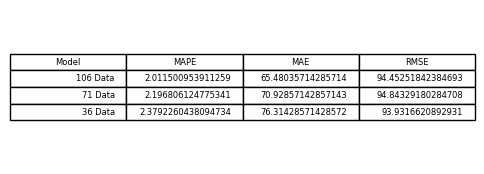

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


def ensure_date_format(date_str, year):
    try:
        return pd.to_datetime(date_str, format='%d-%b-%Y')
    except ValueError:
        try:
            return pd.to_datetime(date_str, format='%Y-%m-%d')
        except ValueError:
            try:
                return pd.to_datetime(date_str, format='%m/%d/%Y')
            except ValueError:
                try:
                    return pd.to_datetime(date_str + f'/{year}', format='%m/%d/%Y')
                except ValueError:
                    return pd.to_datetime(date_str + f'-{year}', format='%d-%b-%Y')

def augment_data(file_path, output_path, year=2020):
    df = pd.read_csv(file_path)
    df['Date'] = df['Date'].apply(lambda x: ensure_date_format(x, year))
    augmented_rows = []
    for i in range(len(df) - 1):
        current_date = df.iloc[i]['Date']
        next_date = df.iloc[i+1]['Date']
        days_between = (next_date - current_date).days
        if days_between > 1:
            mean_value = df.iloc[i:i+2]['Harga'].mean()
            new_row = df.iloc[i].copy()
            new_row['Harga'] = mean_value
            new_row['Date'] = current_date + pd.DateOffset(days=1)
            augmented_rows.append(new_row)
    df_augmented = pd.DataFrame(augmented_rows)
    df_combined = pd.concat([df, df_augmented]).sort_values(by='Date').reset_index(drop=True)
    df_combined.to_csv(output_path, index=False)
    return df_combined

def determine_interval(value, intervals, k):
    for i, interval in enumerate(intervals):
        if interval[0] <= value < interval[1]:
            # print(f"Interval: {interval[0]} - {interval[1]}")
            return f'A{i+1}'
    return f'A{k}'  # untuk nilai yang tepat sama dengan batas atas

def predict_next_price(input_price, intervals, interval_medians, flrg, k):
    input_interval = determine_interval(input_price, intervals, k)
    if input_interval in flrg:
        return flrg[input_interval]
    else:
        return None

def calculate_flrg(df):
    n = len(df)
    k = 1 + 3.322 * math.log10(n)
    # print(f"Nilai k: {k}")
    k = int(round(k))
    print(f"Jumlah kelas (k): {k}")
    range_data = df['Harga'].max() - df['Harga'].min()
    width = range_data / k
    intervals = []
    start = df['Harga'].min()


    for i in range(k):
        end = start + width
        intervals.append((start, end))
        start = end
    interval_medians = {}
    for i, interval in enumerate(intervals):
        median = (interval[0] + interval[1]) / 2
        interval_medians[f'A{i+1}'] = median
        print(f"A{i+1}: {interval[0]} - {interval[1]} dengan nilai median {median}")
    relationships = []
    for i in range(len(df) - 1):
        current_class = determine_interval(df.iloc[i]['Harga'], intervals, k)
        next_class = determine_interval(df.iloc[i + 1]['Harga'], intervals, k)
        relationships.append((current_class, next_class))
    relationship_dict = {}
    for current, next_ in relationships:
        if current not in relationship_dict:
            relationship_dict[current] = set()
        relationship_dict[current].add(next_)
    flrg = {}
    for current in relationship_dict:
        next_intervals = list(relationship_dict[current])
        relevant_medians = [interval_medians[interval] for interval in next_intervals]
        flrg[current] = np.mean(relevant_medians)
    return flrg, intervals, interval_medians, k, relationships

def print_flrg_mapping(relationships):
    print("\nHasil Mapping FLRG:")
    flrg = {}
    for current, next_ in relationships:
        if current not in flrg:
            flrg[current] = set()
        flrg[current].add(next_)
    
    for current, next_set in sorted(flrg.items()):
        next_classes = ','.join(sorted(next_set))
        print(f"{current} -> {next_classes}")

# def plot_membership_functions(intervals, interval_medians):
#     plt.figure(figsize=(10, 6))
#     for i, interval in enumerate(intervals):
#         x = [interval[0], interval_medians[f'A{i+1}'], interval[1]]
#         y = [0, 1, 0]
#         plt.plot(x, y, label=f'A{i+1}')
    
#     plt.xlabel('Harga')
#     plt.ylabel('Membership Degree')
#     plt.title('Triangular Membership Functions')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# Main program
input_file_path = 'harga_singkong.csv'
output_file_path = 'harga_singkong_augmented.csv'
input_file_path2 = 'harga_singkong_augmented.csv'
output_file_path2 = 'harga_singkong_augmented2.csv'
validation_file_path = 'validation.csv'

df = pd.read_csv(output_file_path2)

# df_combined = augment_data(input_file_path2, output_file_path2)
# print("Data gabungan telah disimpan ke file:", output_file_path2)
# # print(df_combined)

# print("
# flrg, intervals, interval_medians, k, relationships= calculate_flrg(df)
# print("\nMapping FLRG untuk seluruh dataset:")
# print_flrg_mapping(relationships)
# plot_membership_functions(intervals, interval_medians)

# Perhitungan pertama: Split dataset 70:30
# Hanya menggunakan 70% data sebagai training
print("\n--- Perhitungan dengan Split Dataset 70:30 ---")
train_df, val_df = train_test_split(df, test_size=0.3, shuffle=False)

flrg, intervals, interval_medians, k, relationships = calculate_flrg(train_df)
# print(f"Nilai k yang digunakan: {k}")
# print("\nNilai FLRG:")
# for key in sorted(flrg.keys()):
#     print(f"{key} -> {flrg[key]}")

# Prediksi untuk set validasi (30% data)
predicted_prices = []
for i in range(len(val_df)):
    current_price = val_df.iloc[i]['Harga']
    predicted_price = predict_next_price(current_price, intervals, interval_medians, flrg, k)
    predicted_prices.append(predicted_price)

val_df['Predicted'] = predicted_prices

# Menghitung MAPE untuk set validasi (30% data)
mape = np.mean(np.abs((val_df['Harga'] - val_df['Predicted']) / val_df['Harga'])) * 100
print(f"MAPE pada set validasi (30% data): {mape:.5f}%")

# Menampilkan beberapa prediksi
# print("\nBeberapa prediksi pada set validasi (30% data):")
# print(val_df[['Date', 'Harga', 'Predicted']].head())

# Perhitungan kedua: Menggunakan file validasi.csv
# Disini seluruh data digunakan sebagai training
print("\n--- Perhitungan dengan File Validasi Eksternal ---")

# Menggunakan seluruh data untuk training
flrg, intervals, interval_medians, k, relationships= calculate_flrg(df)

# Membaca data validasi
external_val_df = pd.read_csv(validation_file_path)

# Prediksi untuk set validasi eksternal
predicted_prices = []
for price in external_val_df['Input']:
    predicted_price = predict_next_price(price, intervals, interval_medians, flrg, k)
    predicted_prices.append(predicted_price)

external_val_df['Predicted'] = predicted_prices

# Menghitung mape_1 untuk set validasi eksternal
mape_1 = np.mean(np.abs((external_val_df['Real_values'] - external_val_df['Predicted']) / external_val_df['Real_values'])) * 100
print(f"MAPE pada set validasi eksternal: {mape_1:.5f}%")

# Menampilkan beberapa prediksi
# print("\nBeberapa prediksi pada set validasi eksternal:")
# print(external_val_df.head())

# Opsi: Menampilkan statistik tambahan untuk validasi eksternal
mae_1 = np.mean(np.abs(external_val_df['Real_values'] - external_val_df['Predicted']))
rmse_1 = np.sqrt(np.mean((external_val_df['Real_values'] - external_val_df['Predicted'])**2))
print(f"\nStatistik tambahan untuk validasi eksternal:")
print(f"mae_1: {mae_1:.2f}")
print(f"rmse_1: {rmse_1:.2f}")



# # Print input file predicted prices
# for i, price in enumerate(predicted_prices):
#     print(f"Prediksi harga ke-{i+1}: {price}")

# # Print user input predicted prices
# print("Input your price: ")
# price = float(input())
# predicted_price = predict_next_price(price, intervals, interval_medians, flrg, k)
# print(f"Predicted price: {predicted_price}")



# Data yang diberikan

# import matplotlib.pyplot as plt

# data = {
#     "Class": ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8"],
#     "Batas Bawah": [3077.00, 3124.25, 3171.50, 3218.75, 3266.00, 3313.25, 3360.50, 3407.75],
#     "Median": [3100.625, 3147.875, 3195.125, 3242.375, 3289.625, 3336.875, 3384.125, 3431.375],
#     "Batas Atas": [3124.25, 3171.50, 3218.75, 3266.00, 3313.25, 3360.50, 3407.75, 3455.00]
# }

# # Transpose the data
# transposed_data = list(zip(*data.values()))

# fig, ax = plt.subplots(figsize=(6, 2))

# # Create the table
# table = ax.table(cellText=transposed_data,
#                  colLabels=list(data.keys()),
#                  loc='center')


# # Remove table lines and center the text
# table.auto_set_font_size(False)
# table.set_fontsize(12)
# table.scale(1.2, 1.2)

# for key, cell in table.get_celld().items():
#     cell.set_edgecolor('none')
#     cell.set_text_props(ha='center', va='center')
#     # Set the header color gray
#     if key[0] == 0:
#         cell.set_text_props(weight='bold', color='#000000')
#         cell.set_facecolor('#D3D3D3')

# # Remove x and y axes
# ax.axis('off')
# # Display the table
# # plt.show()
# plt.savefig("table.jpg")

# Menggunakan augmented.csv
print("\n\n\n")
print(f"--- Menggunakan augmented.csv ---")
df = pd.read_csv(output_file_path)
flrg, intervals, interval_medians, k, relationships = calculate_flrg(df)


# Prediksi untuk set validasi 
external_val_df = pd.read_csv(validation_file_path)
predicted_prices = []
for price in external_val_df['Input']:
    predicted_price = predict_next_price(price, intervals, interval_medians, flrg, k)
    predicted_prices.append(predicted_price)

external_val_df['Predicted'] = predicted_prices
mape_2 = np.mean(np.abs((external_val_df['Real_values'] - external_val_df['Predicted']) / external_val_df['Real_values'])) * 100
print(f"mape_2 pada set validasi eksternal: {mape_2:.5f}%")

# Opsi: Menampilkan statistik tambahan untuk validasi eksternal
mae_2 = np.mean(np.abs(external_val_df['Real_values'] - external_val_df['Predicted']))
rmse_2 = np.sqrt(np.mean((external_val_df['Real_values'] - external_val_df['Predicted'])**2))
print(f"\nStatistik tambahan untuk validasi eksternal:")
print(f"mae_2: {mae_2:.2f}")
print(f"rmse_2: {rmse_2:.2f}")


# Tanpa augmentasi
print("\n\n\n")
print(f"--- Tanpa augmentasi ---")
df = pd.read_csv(input_file_path)
flrg, intervals, interval_medians, k, relationships = calculate_flrg(df)

# Prediksi untuk set validasi
external_val_df = pd.read_csv(validation_file_path)
predicted_prices = []
for price in external_val_df['Input']:
    predicted_price = predict_next_price(price, intervals, interval_medians, flrg, k)
    predicted_prices.append(predicted_price)

external_val_df['Predicted'] = predicted_prices
mape_3 = np.mean(np.abs((external_val_df['Real_values'] - external_val_df['Predicted']) / external_val_df['Real_values'])) * 100
print(f"mape_3 pada set validasi eksternal: {mape_3:.5f}%")
print("Harga prediksi bulan depan: ")
print(external_val_df['Predicted'].iloc[-1])

# Opsi: Menampilkan statistik tambahan untuk validasi eksternal
mae_3 = np.mean(np.abs(external_val_df['Real_values'] - external_val_df['Predicted']))
rmse_3 = np.sqrt(np.mean((external_val_df['Real_values'] - external_val_df['Predicted'])**2))
print(f"\nStatistik tambahan untuk validasi eksternal:")
print(f"mae_3: {mae_3:.2f}")
print(f"rmse_3: {rmse_3:.2f}")


# Tabel perbandingan antara jumlah data 106, 71, dan 36
data = {
    "Model": ["106 Data", "71 Data", "36 Data"],
    "MAPE": [mape_1, mape_2, mape_3],
    "MAE": [mae_1, mae_2, mae_3],
    "RMSE": [rmse_1, rmse_2, rmse_3]
}


transposed_data = list(zip(*data.values()))
plt.figure(figsize=(6, 2))
table = plt.table(cellText=transposed_data,
                    colLabels=list(data.keys()),
                    loc='center')
plt.axis('off')
plt.savefig("table.jpg")